<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/7.modern_convolutional_neural_networks/7_4_networks_with_parallel_concatenations_goog_le_net_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import tensorflow as tf
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [11]:
class Inception(tf.keras.Model):

  def __init__(self, c1, c2, c3, c4):
    super().__init__()
    self.p1_1 = tf.keras.layers.Conv2D(c1, 1, activation='relu')

    self.p2_1 = tf.keras.layers.Conv2D(c2[0], 1, activation='relu')
    self.p2_2 = tf.keras.layers.Conv2D(c2[1], 3, padding='same',
                                           activation='relu')
    
    self.p3_1 = tf.keras.layers.Conv2D(c3[0], 1, activation='relu')
    self.p3_2 = tf.keras.layers.Conv2D(c3[1], 5, padding='same',
                                           activation='relu')
    
    self.p4_1 = tf.keras.layers.MaxPool2D(3, 1, padding='same')
    self.p4_2 = tf.keras.layers.Conv2D(c4, 1, activation='relu')

  def call(self, x):
    p1 = self.p1_1(x)
    p2 = self.p2_2(self.p2_1(x))
    p3 = self.p3_2(self.p3_1(x))
    p4 = self.p4_2(self.p4_1(x))
    return tf.keras.layers.Concatenate()([p1, p2, p3, p4])

In [12]:
def b1():
  return tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, 7, strides=2, padding='same',
                               activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')   
  ])

In [13]:
def b2():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 1, activation='relu'),
        tf.keras.layers.Conv2D(192, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [14]:
def b3():
    return tf.keras.models.Sequential([
        Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [15]:
def b4():
    return tf.keras.Sequential([
        Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(112, (144, 288), (32, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [16]:
def b5():
    return tf.keras.Sequential([
        Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Flatten()])

In [17]:
def net():
    return tf.keras.Sequential([b1(), b2(), b3(), b4(), b5(),
                                tf.keras.layers.Dense(10)])

In [18]:
X = tf.random.uniform(shape=(1, 96, 96, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 (1, 24, 24, 64)
Sequential output shape:	 (1, 12, 12, 192)
Sequential output shape:	 (1, 6, 6, 480)
Sequential output shape:	 (1, 3, 3, 832)
Sequential output shape:	 (1, 1024)
Dense output shape:	 (1, 10)


In [19]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # Divide all numbers by 255 so that all pixel values are between
    # 0 and 1, add a batch dimension at the last. And cast label to int32
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (
        tf.image.resize_with_pad(X, resize, resize) if resize else X, y)
    return (
        tf.data.Dataset.from_tensor_slices(process(*mnist_train)).batch(
            batch_size).shuffle(len(mnist_train[0])).map(resize_fn),
        tf.data.Dataset.from_tensor_slices(process(*mnist_test)).batch(
            batch_size).map(resize_fn))

In [20]:
def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr, device):
  device_name = device._device_name
  strategy = tf.distribute.OneDeviceStrategy(device_name)
  with strategy.scope():
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    net = net_fn()
    net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[PlotLossesKeras()])
  return net

In [21]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if len(tf.config.experimental.list_physical_devices('GPU')) >= i + 1:
        return tf.device(f'/GPU:{i}')
    return tf.device('/CPU:0')

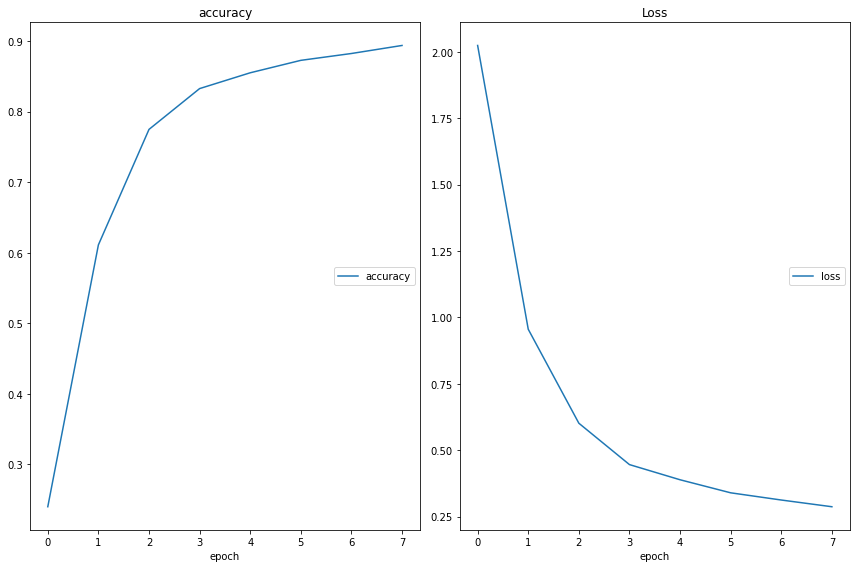

accuracy
	accuracy         	 (min:    0.240, max:    0.894, cur:    0.894)
Loss
	loss             	 (min:    0.287, max:    2.024, cur:    0.287)


In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())